<a href="https://colab.research.google.com/github/Santhosh-12345/GFG/blob/main/CIP_INITIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa numpy scipy matplotlib pandas joblib tsfresh


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.2 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os

# Define the path to your dataset
data_dir = '/content/drive/My Drive/Circor_Dataset'

# List files to confirm access
files = sorted([f for f in os.listdir(data_dir) if f.endswith('.wav')])
print(f"Total files found: {len(files)}")
print(files[:5])  # Print the first 5 files to verify


Total files found: 657
['13918_AV.wav', '13918_MV.wav', '13918_PV.wav', '13918_TV.wav', '14241_AV.wav']


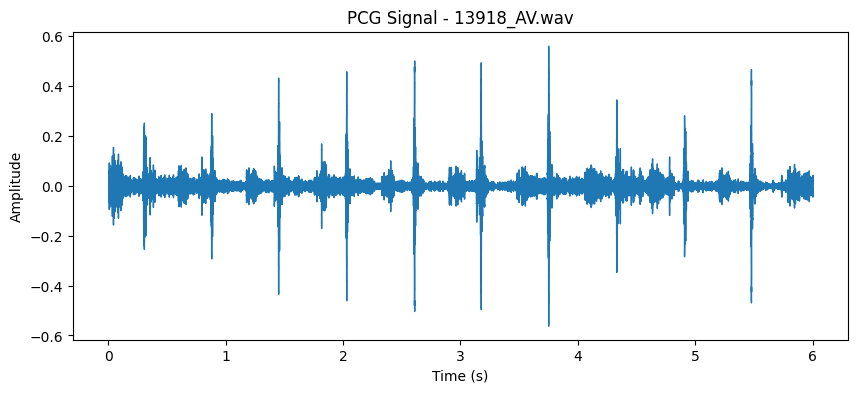

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load and visualize the first file
sample_file = os.path.join(data_dir, files[0])
y, sr = librosa.load(sample_file, sr=4000)  # Sampling rate as per dataset

# Plot the first 6 seconds
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y[:sr*6], sr=sr)
plt.title(f"PCG Signal - {files[0]}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


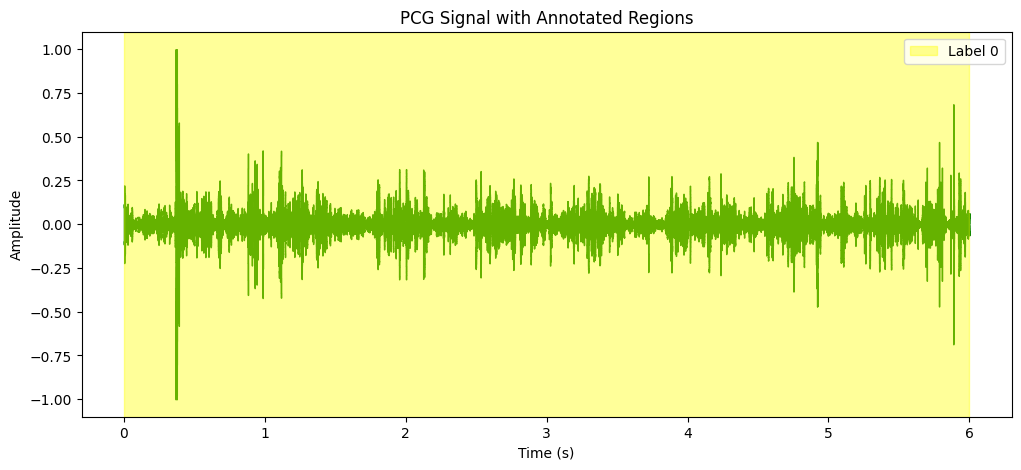

In [8]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Dataset path
data_dir = '/content/drive/My Drive/Circor_Dataset'

def load_annotations(tsv_file):
    """Load annotations from TSV file and handle unannotated regions."""
    df = pd.read_csv(tsv_file, sep='\t', header=None, names=['start', 'end', 'label'])
    intervals = []

    prev_end = 0.0
    for _, row in df.iterrows():
        # Handle unannotated gap before the current interval
        if row['start'] > prev_end:
            intervals.append((prev_end, row['start'], -1))  # Unannotated region
        intervals.append((row['start'], row['end'], int(row['label'])))
        prev_end = row['end']

    return intervals

def label_signal(y, sr, intervals):
    """Generate labeled array for the signal based on intervals."""
    labels = np.full(len(y), -1)  # Initialize with -1 for unannotated
    for start, end, label in intervals:
        start_idx = int(start * sr)
        end_idx = int(end * sr)
        labels[start_idx:end_idx] = label
    return labels

# Process the first file to test
wav_file = os.path.join(data_dir, '9979_AV.wav')
tsv_file = os.path.join(data_dir, '9979_AV.tsv')

# Load signal and annotations
y, sr = librosa.load(wav_file, sr=4000)
intervals = load_annotations(tsv_file)
labels = label_signal(y, sr, intervals)

# Plot the first 6 seconds with labeled regions
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y[:sr*6], sr=sr, color='green')
time_axis = np.linspace(0, 6, sr*6)
for start, end, label in intervals:
    if start >= 6:
        break
    plt.axvspan(start, min(end, 6), color='lightblue' if label == -1 else 'yellow', alpha=0.4, label=f"Label {label}")
plt.title("PCG Signal with Annotated Regions")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.show()


In [16]:
import os
import librosa
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import soundfile as sf  # Import soundfile for saving WAV files

# List of Patient IDs
patient_ids = [
    9979, 13918, 14241, 29045, 33151, 40840, 44514, 46065, 49627, 49628, 49691,
    49994, 50229, 50238, 50256, 50260, 50277, 50289, 50319, 50331, 50676, 50744,
    50746, 50757, 50781, 55945, 57706, 61117, 68255, 68423, 68432, 68444, 68708,
    68740, 69093, 73497, 76240, 77373, 84692, 84693, 84695, 84718, 84751, 84834,
    84853, 84854, 84863, 84864, 84865, 84882, 84896, 84937, 84949, 85002, 85024,
    85030, 85031, 85036, 85037, 85042, 85057, 85069, 85079, 85080, 85087, 85108,
    85110, 85119, 85132, 85133, 85169, 85172, 85198, 85207, 85219, 85261, 85343,
    85293, 50713, 50388, 68711, 50708, 50271, 84851, 85164, 85249, 84986, 84994,
    50773, 85210, 68316, 84706, 85262, 68660, 85312, 50689, 85121, 85282, 50017,
    50751, 84838, 43852, 49995, 84785, 84973, 85094, 68738, 50386, 50820, 50647,
    85213, 50029, 85128, 50687, 85038, 85328, 85175, 50800, 49988, 84887, 84974,
    50007, 84936, 85316, 84912, 63456, 49999, 49853, 85176, 39043, 50244, 85334,
    84852, 50393, 85340, 84883, 50788, 84742, 49980, 84933, 84960, 68431, 50103,
    85225, 84987, 49610, 50784, 85161, 49990, 84935, 69174, 49719, 84945, 84985,
    84735, 68412, 50807, 84724, 68646, 85217, 69141, 85250, 50763, 85147
]

# Dataset path and output path
data_dir = '/content/drive/My Drive/Circor_Dataset'
output_dir = '/content/drive/My Drive/Circor_Dataset/Filtered'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Bandpass filter function (25-400 Hz)
def butter_bandpass_filter(data, lowcut=25, highcut=400, fs=4000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Process files for the specified patients
for patient_id in patient_ids:
    for valve in ['AV', 'MV', 'PV', 'TV']:
        wav_file = os.path.join(data_dir, f'{patient_id}_{valve}.wav')
        tsv_file = os.path.join(data_dir, f'{patient_id}_{valve}.tsv')

        # Debugging: Print the file paths to check if they are correct
        print(f"Checking: {wav_file}, {tsv_file}")

        # Check if both .wav and .tsv files exist for this patient and valve
        if os.path.exists(wav_file) and os.path.exists(tsv_file):
            print(f"Processing {wav_file} and {tsv_file}")

            # Load the audio file
            y, sr = librosa.load(wav_file, sr=4000)

            # Apply the bandpass filter
            y_filtered = butter_bandpass_filter(y)

            # Save the filtered audio file using soundfile.write
            filtered_file = os.path.join(output_dir, f'{patient_id}_{valve}_filtered.wav')
            sf.write(filtered_file, y_filtered, sr)  # Use soundfile to save

            print(f"Filtered and saved: {filtered_file}")
        else:
            # Print missing files
            if not os.path.exists(wav_file):
                print(f"Missing .wav file for Patient {patient_id} Valve {valve}")
            if not os.path.exists(tsv_file):
                print(f"Missing .tsv file for Patient {patient_id} Valve {valve}")

print("✅ Filtering completed for all available patient files.")


Checking: /content/drive/My Drive/Circor_Dataset/9979_AV.wav, /content/drive/My Drive/Circor_Dataset/9979_AV.tsv
Processing /content/drive/My Drive/Circor_Dataset/9979_AV.wav and /content/drive/My Drive/Circor_Dataset/9979_AV.tsv
Filtered and saved: /content/drive/My Drive/Circor_Dataset/Filtered/9979_AV_filtered.wav
Checking: /content/drive/My Drive/Circor_Dataset/9979_MV.wav, /content/drive/My Drive/Circor_Dataset/9979_MV.tsv
Processing /content/drive/My Drive/Circor_Dataset/9979_MV.wav and /content/drive/My Drive/Circor_Dataset/9979_MV.tsv
Filtered and saved: /content/drive/My Drive/Circor_Dataset/Filtered/9979_MV_filtered.wav
Checking: /content/drive/My Drive/Circor_Dataset/9979_PV.wav, /content/drive/My Drive/Circor_Dataset/9979_PV.tsv
Processing /content/drive/My Drive/Circor_Dataset/9979_PV.wav and /content/drive/My Drive/Circor_Dataset/9979_PV.tsv
Filtered and saved: /content/drive/My Drive/Circor_Dataset/Filtered/9979_PV_filtered.wav
Checking: /content/drive/My Drive/Circor_Da

In [18]:
import librosa
import numpy as np
import os
import pandas as pd

# Path to filtered files
filtered_dir = '/content/drive/My Drive/Circor_Dataset/Filtered'
# Path to save the extracted features
features_dir = '/content/drive/My Drive/Circor_Dataset/Features'

# Ensure the features directory exists
os.makedirs(features_dir, exist_ok=True)

# List of patient IDs (replace with your actual list of 165 patient IDs)
patient_ids = [
    9979, 13918, 14241, 29045, 33151, 40840, 44514, 46065, 49627, 49628, 49691,
    49994, 50229, 50238, 50256, 50260, 50277, 50289, 50319, 50331, 50676, 50744,
    50746, 50757, 50781, 55945, 57706, 61117, 68255, 68423, 68432, 68444, 68708,
    68740, 69093, 73497, 76240, 77373, 84692, 84693, 84695, 84718, 84751, 84834,
    84853, 84854, 84863, 84864, 84865, 84882, 84896, 84937, 84949, 85002, 85024,
    85030, 85031, 85036, 85037, 85042, 85057, 85069, 85079, 85080, 85087, 85108,
    85110, 85119, 85132, 85133, 85169, 85172, 85198, 85207, 85219, 85261, 85343,
    85293, 50713, 50388, 68711, 50708, 50271, 84851, 85164, 85249, 84986, 84994,
    50773, 85210, 68316, 84706, 85262, 68660, 85312, 50689, 85121, 85282, 50017,
    50751, 84838, 43852, 49995, 84785, 84973, 85094, 68738, 50386, 50820, 50647,
    85213, 50029, 85128, 50687, 85038, 85328, 85175, 50800, 49988, 84887, 84974,
    50007, 84936, 85316, 84912, 63456, 49999, 49853, 85176, 39043, 50244, 85334,
    84852, 50393, 85340, 84883, 50788, 84742, 49980, 84933, 84960, 68431, 50103,
    85225, 84987, 49610, 50784, 85161, 49990, 84935, 69174, 49719, 84945, 84985,
    84735, 68412, 50807, 84724, 68646, 85217, 69141, 85250, 50763, 85147
]

# Function to extract MFCC features from a WAV file
def extract_mfcc(wav_file, n_mfcc=13, sr=4000):
    # Load the audio file
    y, sr = librosa.load(wav_file, sr=sr)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Mean of each MFCC feature (over time), this will reduce dimensionality
    mfcc_mean = np.mean(mfcc, axis=1)

    return mfcc_mean

# Process all filtered files and extract MFCCs
for patient_id in patient_ids:
    for valve in ['AV', 'MV', 'PV', 'TV']:
        # Define the path for filtered files
        filtered_file = os.path.join(filtered_dir, f'{patient_id}_{valve}_filtered.wav')

        if os.path.exists(filtered_file):
            # Extract MFCCs
            mfcc_features = extract_mfcc(filtered_file)

            # Save features to a CSV file for future use
            features_file = os.path.join(features_dir, f'{patient_id}_{valve}_features.csv')
            pd.DataFrame(mfcc_features).to_csv(features_file, header=False, index=False)

            print(f"Extracted and saved MFCC features for: {filtered_file}")
        else:
            print(f"Filtered file missing for Patient {patient_id} Valve {valve}")

print("✅ MFCC feature extraction completed for all filtered files.")


Extracted and saved MFCC features for: /content/drive/My Drive/Circor_Dataset/Filtered/9979_AV_filtered.wav
Extracted and saved MFCC features for: /content/drive/My Drive/Circor_Dataset/Filtered/9979_MV_filtered.wav
Extracted and saved MFCC features for: /content/drive/My Drive/Circor_Dataset/Filtered/9979_PV_filtered.wav
Extracted and saved MFCC features for: /content/drive/My Drive/Circor_Dataset/Filtered/9979_TV_filtered.wav
Extracted and saved MFCC features for: /content/drive/My Drive/Circor_Dataset/Filtered/13918_AV_filtered.wav
Extracted and saved MFCC features for: /content/drive/My Drive/Circor_Dataset/Filtered/13918_MV_filtered.wav
Extracted and saved MFCC features for: /content/drive/My Drive/Circor_Dataset/Filtered/13918_PV_filtered.wav
Extracted and saved MFCC features for: /content/drive/My Drive/Circor_Dataset/Filtered/13918_TV_filtered.wav
Extracted and saved MFCC features for: /content/drive/My Drive/Circor_Dataset/Filtered/14241_AV_filtered.wav
Extracted and saved MFC

In [19]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the filtered.csv file that contains the patient IDs and labels
filtered_csv_path = '/content/drive/My Drive/Circor_Dataset/filtered.csv'
filtered_df = pd.read_csv(filtered_csv_path)

# Check if the filtered dataset has the necessary columns
filtered_df.head()

# Initialize lists for features and labels
X = []  # List for storing features (MFCCs)
y = []  # List for storing labels (Murmur presence/absence)

# Directory containing the MFCC feature files
features_dir = '/content/drive/My Drive/Circor_Dataset/Features'

# Create a LabelEncoder to encode the "Present" and "Absent" labels
label_encoder = LabelEncoder()

# Iterate through each row in the filtered dataset
for index, row in filtered_df.iterrows():
    patient_id = row['Patient ID']
    murmur_label = row['Murmur']  # This should be "Present" or "Absent"

    # Encoding the label
    label_encoded = label_encoder.fit_transform([murmur_label])[0]

    # Now check and load the corresponding MFCC feature files for each valve
    for valve in ['AV', 'MV', 'PV', 'TV']:
        features_file = os.path.join(features_dir, f'{patient_id}_{valve}_features.csv')

        if os.path.exists(features_file):
            # Load the features (MFCC)
            mfcc_features = pd.read_csv(features_file, header=None).values.flatten()
            X.append(mfcc_features)
            y.append(label_encoded)
            print(f"Processed: {patient_id}_{valve}")
        else:
            print(f"Missing MFCC feature file for {patient_id}_{valve}")

# Convert the feature list and label list into numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing datasets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Preparation Completed: {X_train.shape}, {y_train.shape}")


Processed: 9979_AV
Processed: 9979_MV
Processed: 9979_PV
Processed: 9979_TV
Processed: 13918_AV
Processed: 13918_MV
Processed: 13918_PV
Processed: 13918_TV
Processed: 14241_AV
Processed: 14241_MV
Processed: 14241_PV
Processed: 14241_TV
Processed: 29045_AV
Processed: 29045_MV
Processed: 29045_PV
Processed: 29045_TV
Processed: 33151_AV
Processed: 33151_MV
Processed: 33151_PV
Processed: 33151_TV
Processed: 40840_AV
Processed: 40840_MV
Processed: 40840_PV
Processed: 40840_TV
Processed: 44514_AV
Processed: 44514_MV
Processed: 44514_PV
Processed: 44514_TV
Processed: 46065_AV
Processed: 46065_MV
Processed: 46065_PV
Processed: 46065_TV
Processed: 49627_AV
Processed: 49627_MV
Processed: 49627_PV
Processed: 49627_TV
Processed: 49628_AV
Processed: 49628_MV
Processed: 49628_PV
Processed: 49628_TV
Processed: 49691_AV
Processed: 49691_MV
Processed: 49691_PV
Processed: 49691_TV
Processed: 49994_AV
Processed: 49994_MV
Processed: 49994_PV
Processed: 49994_TV
Processed: 50229_AV
Processed: 50229_MV
Proc

In [20]:
# Save the features and labels to disk
np.save('/content/drive/My Drive/Circor_Dataset/X_train.npy', X_train)
np.save('/content/drive/My Drive/Circor_Dataset/y_train.npy', y_train)
np.save('/content/drive/My Drive/Circor_Dataset/X_test.npy', X_test)
np.save('/content/drive/My Drive/Circor_Dataset/y_test.npy', y_test)

print("Data saved successfully!")


Data saved successfully!


In [21]:
import pandas as pd
import os

# Directory containing the MFCC feature files
features_dir = '/content/drive/My Drive/Circor_Dataset/Features'

# Initialize an empty list to hold the data
all_features = []

# Iterate through each row in the filtered dataset
for index, row in filtered_df.iterrows():
    patient_id = row['Patient ID']

    # Initialize a list for this patient, starting with the patient ID
    patient_features = [patient_id]

    # For each valve, check if the corresponding MFCC file exists and append the features
    for valve in ['AV', 'MV', 'PV', 'TV']:
        features_file = os.path.join(features_dir, f'{patient_id}_{valve}_features.csv')

        if os.path.exists(features_file):
            # Load the features (MFCC)
            mfcc_features = pd.read_csv(features_file, header=None).values.flatten()
            patient_features.extend(mfcc_features)  # Add MFCC features to the list
        else:
            print(f"Missing MFCC feature file for {patient_id}_{valve}")

    # Append the patient's features to the all_features list
    all_features.append(patient_features)

# Convert the list of all features to a DataFrame
columns = ['Patient ID'] + [f'MFCC_{i}' for i in range(1, len(patient_features))]
features_df = pd.DataFrame(all_features, columns=columns)

# Save the DataFrame to a CSV file
features_csv_path = '/content/drive/My Drive/Circor_Dataset/all_patient_mfccs.csv'
features_df.to_csv(features_csv_path, index=False)

print(f"MFCC features saved to {features_csv_path}")


MFCC features saved to /content/drive/My Drive/Circor_Dataset/all_patient_mfccs.csv


In [22]:
import os
import librosa
import matplotlib.pyplot as plt

# Directory for filtered files
filtered_files_dir = '/content/drive/My Drive/Circor_Dataset/Filtered'

# Directory to save waveforms as PNG images
waveform_output_dir = '/content/drive/My Drive/Circor_Dataset/Filtered_Waveforms_Images'

# Create the output directory if it doesn't exist
if not os.path.exists(waveform_output_dir):
    os.makedirs(waveform_output_dir)

# List of patient IDs
patient_ids = [
    9979, 13918, 14241, 29045, 33151, 40840, 44514, 46065, 49627, 49628,
    49691, 49994, 50229, 50238, 50256, 50260, 50277, 50289, 50319, 50331,
    50676, 50744, 50746, 50757, 50781, 55945, 57706, 61117, 68255, 68423,
    68432, 68444, 68708, 68740, 69093, 73497, 76240, 77373, 84692, 84693,
    84695, 84718, 84751, 84834, 84853, 84854, 84863, 84864, 84865, 84882,
    84896, 84937, 84949, 85002, 85024, 85030, 85031, 85036, 85037, 85042,
    85057, 85069, 85079, 85080, 85087, 85108, 85110, 85119, 85132, 85133,
    85169, 85172, 85198, 85207, 85219, 85261, 85343, 85293, 50713, 50388,
    68711, 50708, 50271, 84851, 85164, 85249, 84986, 84994, 50773, 85210,
    68316, 84706, 85262, 68660, 85312, 50689, 85121, 85282, 50017, 50751,
    84838, 43852, 49995, 84785, 84973, 85094, 68738, 50386, 50820, 50647,
    85213, 50029, 85128, 50687, 85038, 85328, 85175, 50800, 49988, 84887,
    84974, 50007, 84936, 85316, 84912, 63456, 49999, 49853, 85176, 39043,
    50244, 85334, 84852, 50393, 85340, 84883, 50788, 84742, 49980, 84933,
    84960, 68431, 50103, 85225, 84987, 49610, 50784, 85161, 49990, 84935,
    69174, 49719, 84945, 84985, 84735, 68412, 50807, 84724, 68646, 85217,
    69141, 85250, 50763, 85147
]

# Iterate through each patient ID
for patient_id in patient_ids:
    for valve in ['AV', 'MV', 'PV', 'TV']:  # For each valve recording
        # Construct the path to the filtered .wav file
        filtered_file = os.path.join(filtered_files_dir, f'{patient_id}_{valve}_filtered.wav')

        if os.path.exists(filtered_file):
            # Load the filtered audio file
            y, sr = librosa.load(filtered_file)

            # Create a plot for the waveform
            plt.figure(figsize=(10, 4))
            librosa.display.waveshow(y, sr=sr)
            plt.title(f'Patient {patient_id} - {valve} Waveform')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')

            # Save the plot as PNG
            output_image = os.path.join(waveform_output_dir, f'{patient_id}_{valve}_waveform.png')
            plt.savefig(output_image, bbox_inches='tight')
            plt.close()
            print(f"Waveform saved for {patient_id}_{valve}")
        else:
            print(f"Filtered file not found for {patient_id}_{valve}")


Waveform saved for 9979_AV
Waveform saved for 9979_MV
Waveform saved for 9979_PV
Waveform saved for 9979_TV
Waveform saved for 13918_AV
Waveform saved for 13918_MV
Waveform saved for 13918_PV
Waveform saved for 13918_TV
Waveform saved for 14241_AV
Waveform saved for 14241_MV
Waveform saved for 14241_PV
Waveform saved for 14241_TV
Waveform saved for 29045_AV
Waveform saved for 29045_MV
Waveform saved for 29045_PV
Waveform saved for 29045_TV
Waveform saved for 33151_AV
Waveform saved for 33151_MV
Waveform saved for 33151_PV
Waveform saved for 33151_TV
Waveform saved for 40840_AV
Waveform saved for 40840_MV
Waveform saved for 40840_PV
Waveform saved for 40840_TV
Waveform saved for 44514_AV
Waveform saved for 44514_MV
Waveform saved for 44514_PV
Waveform saved for 44514_TV
Waveform saved for 46065_AV
Waveform saved for 46065_MV
Waveform saved for 46065_PV
Waveform saved for 46065_TV
Waveform saved for 49627_AV
Waveform saved for 49627_MV
Waveform saved for 49627_PV
Waveform saved for 49627

Processed: 9979_AV
Processed: 9979_MV
Processed: 9979_PV
Processed: 9979_TV
Processed: 13918_AV
Processed: 13918_MV
Processed: 13918_PV
Processed: 13918_TV
Processed: 14241_AV
Processed: 14241_MV
Processed: 14241_PV
Processed: 14241_TV
Processed: 29045_AV
Processed: 29045_MV
Processed: 29045_PV
Processed: 29045_TV
Processed: 33151_AV
Processed: 33151_MV
Processed: 33151_PV
Processed: 33151_TV
Processed: 40840_AV
Processed: 40840_MV
Processed: 40840_PV
Processed: 40840_TV
Processed: 44514_AV
Processed: 44514_MV
Processed: 44514_PV
Processed: 44514_TV
Processed: 46065_AV
Processed: 46065_MV
Processed: 46065_PV
Processed: 46065_TV
Processed: 49627_AV
Processed: 49627_MV
Processed: 49627_PV
Processed: 49627_TV
Processed: 49628_AV


KeyboardInterrupt: 

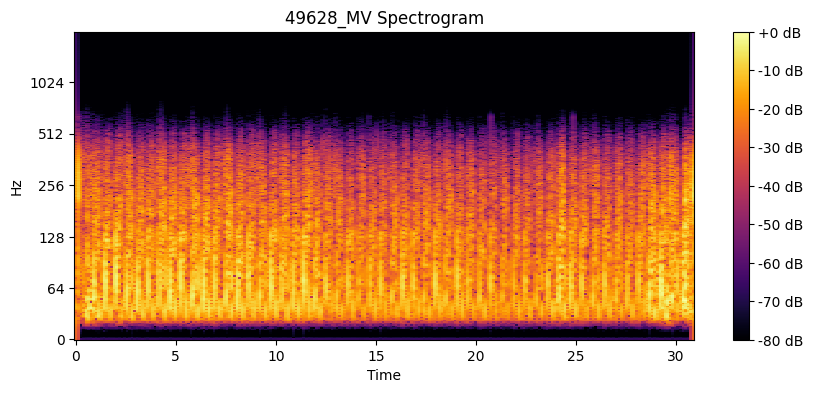